In [127]:
import utils.helper_functions_v2 as hf
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
print("Setup Complete")

Setup Complete


In [173]:
run_random_search = False
league = 'premier-league'
seasons = '2017-2023'
season_test = 2022

In [174]:
# Read the data
X_full, y, X_test_full, y_test, odds_test = hf.get_league_data(league, seasons, season_test)
display(X_full)

,game_date,season,home_team,away_team,home_pts_pct,home_win_pct,home_draw_pct,home_loss_pct,home_home_win_pct,home_home_draw_pct,...,away_away_win_pct,away_away_draw_pct,away_away_loss_pct,away_win_pct_last_games,away_draw_pct_last_games,away_loss_pct_last_games,away_score_last_games,away_conceded_last_games,away_xg_last_games,away_conceded_xg_last_games
0,2017-11-04,2017,Stoke City,Leicester City,36.666667,30.000000,20.000000,50.000000,40.000000,20.000000,...,20.000000,40.000000,40.000000,40.0,40.0,20.0,1.666667,1.333333,1.58,0.94
1,2017-11-04,2017,Southampton,Burnley,43.333333,30.000000,40.000000,30.000000,33.333333,33.333333,...,40.000000,40.000000,20.000000,40.0,40.0,20.0,0.666667,0.333333,0.60,1.18
2,2017-11-04,2017,Swansea City,Brighton,26.666667,20.000000,20.000000,60.000000,20.000000,0.000000,...,20.000000,20.000000,60.000000,40.0,40.0,20.0,1.000000,0.666667,1.00,1.28
3,2017-11-04,2017,Huddersfield,West Brom,40.000000,30.000000,30.000000,40.000000,40.000000,40.000000,...,20.000000,20.000000,60.000000,0.0,40.0,60.0,2.000000,2.500000,0.98,1.84
4,2017-11-04,2017,Newcastle Utd,Bournemouth,46.666667,40.000000,20.000000,40.000000,60.000000,20.000000,...,20.000000,0.000000,80.000000,20.0,20.0,60.0,0.000000,0.500000,0.70,1.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389,2022-05-22,2021,Norwich City,Tottenham,19.819820,13.513514,18.918919,67.567568,16.666667,16.666667,...,44.444444,22.222222,33.333333,60.0,40.0,0.0,2.333333,0.333333,1.52,0.78
1390,2022-05-22,2021,Manchester City,Aston Villa,81.081081,75.675676,16.216216,8.108108,77.777778,11.111111,...,38.888889,5.555556,55.555556,40.0,40.0,20.0,1.250000,1.000000,1.56,1.44
1391,2022-05-22,2021,Liverpool,Wolves,80.180180,72.972973,21.621622,5.405405,77.777778,22.222222,...,44.444444,16.666667,38.888889,0.0,40.0,60.0,0.666667,3.000000,0.94,1.82
1392,2022-05-22,2021,Burnley,Newcastle Utd,31.531532,18.918919,37.837838,43.243243,27.777778,33.333333,...,22.222222,22.222222,55.555556,60.0,0.0,40.0,1.000000,0.333333,1.08,1.42


In [175]:
# Define categorical and numerical columns
categorical_cols, numerical_cols = hf.set_numerical_categorical_cols(X_full)

# Keep selected columns only
X_train, y_train, X_test = hf.filter_datasets(X_full, y, X_test_full, categorical_cols, numerical_cols)

In [176]:
# hf.plot_feature_corr_chart(X_train, numerical_cols)

,season,home_pts_pct,home_win_pct,home_draw_pct,home_loss_pct,home_home_win_pct,home_home_draw_pct,home_home_loss_pct,home_win_pct_last_games,home_draw_pct_last_games,...,away_away_win_pct,away_away_draw_pct,away_away_loss_pct,away_win_pct_last_games,away_draw_pct_last_games,away_loss_pct_last_games,away_score_last_games,away_conceded_last_games,away_xg_last_games,away_conceded_xg_last_games
0,2017.0,36.666667,30.000000,20.000000,50.000000,40.000000,20.000000,40.000000,40.0,0.0,...,20.000000,40.000000,40.000000,40.0,40.0,20.0,1.666667,1.333333,1.58,0.94
1,2017.0,43.333333,30.000000,40.000000,30.000000,33.333333,33.333333,33.333333,20.0,40.0,...,40.000000,40.000000,20.000000,40.0,40.0,20.0,0.666667,0.333333,0.60,1.18
2,2017.0,26.666667,20.000000,20.000000,60.000000,20.000000,0.000000,80.000000,20.0,0.0,...,20.000000,20.000000,60.000000,40.0,40.0,20.0,1.000000,0.666667,1.00,1.28
3,2017.0,40.000000,30.000000,30.000000,40.000000,40.000000,40.000000,20.000000,20.0,20.0,...,20.000000,20.000000,60.000000,0.0,40.0,60.0,2.000000,2.500000,0.98,1.84
4,2017.0,46.666667,40.000000,20.000000,40.000000,60.000000,20.000000,20.000000,20.0,40.0,...,20.000000,0.000000,80.000000,20.0,20.0,60.0,0.000000,0.500000,0.70,1.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389,2021.0,19.819820,13.513514,18.918919,67.567568,16.666667,16.666667,66.666667,0.0,20.0,...,44.444444,22.222222,33.333333,60.0,40.0,0.0,2.333333,0.333333,1.52,0.78
1390,2021.0,81.081081,75.675676,16.216216,8.108108,77.777778,11.111111,11.111111,80.0,20.0,...,38.888889,5.555556,55.555556,40.0,40.0,20.0,1.250000,1.000000,1.56,1.44
1391,2021.0,80.180180,72.972973,21.621622,5.405405,77.777778,22.222222,0.000000,80.0,20.0,...,44.444444,16.666667,38.888889,0.0,40.0,60.0,0.666667,3.000000,0.94,1.82
1392,2021.0,31.531532,18.918919,37.837838,43.243243,27.777778,33.333333,38.888889,40.0,20.0,...,22.222222,22.222222,55.555556,60.0,0.0,40.0,1.000000,0.333333,1.08,1.42


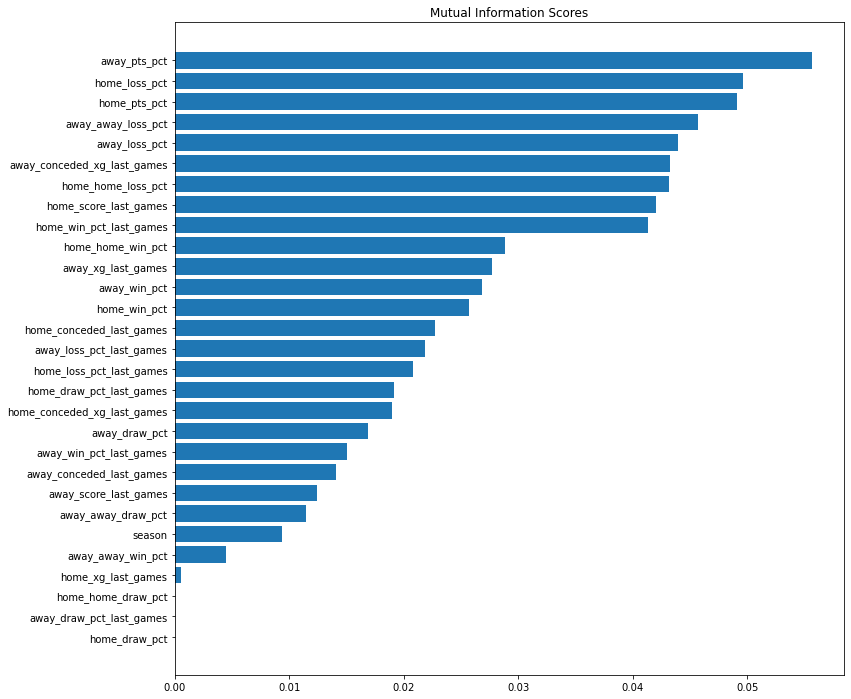

In [177]:
X_train = hf.transform_x(X_train, categorical_cols, numerical_cols)
X_test = hf.transform_x(X_test, categorical_cols, numerical_cols)

display(X_train)
first_mi_scores = hf.make_mi_scores(X_train, y_train)
hf.plot_mi_scores(first_mi_scores)

In [178]:
hf.create_cluster_features(X_train, X_test, first_mi_scores)

Total features to consider when clustering: 29


,season,home_pts_pct,home_win_pct,home_draw_pct,home_loss_pct,home_home_win_pct,home_home_draw_pct,home_home_loss_pct,home_win_pct_last_games,home_draw_pct_last_games,...,Cluster_20,Cluster_21,Cluster_22,Cluster_23,Cluster_24,Cluster_25,Cluster_26,Cluster_27,Cluster_28,Cluster_29
0,2017.0,36.666667,30.000000,20.000000,50.000000,40.000000,20.000000,40.000000,40.0,0.0,...,0,2,2,0,0,3,3,2,3,2
1,2017.0,43.333333,30.000000,40.000000,30.000000,33.333333,33.333333,33.333333,20.0,40.0,...,0,0,2,0,4,1,3,0,2,3
2,2017.0,26.666667,20.000000,20.000000,60.000000,20.000000,0.000000,80.000000,20.0,0.0,...,0,0,0,0,0,3,3,2,4,2
3,2017.0,40.000000,30.000000,30.000000,40.000000,40.000000,40.000000,20.000000,20.0,20.0,...,1,2,4,0,0,3,3,0,2,1
4,2017.0,46.666667,40.000000,20.000000,40.000000,60.000000,20.000000,20.000000,20.0,40.0,...,3,0,0,0,0,3,1,4,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389,2021.0,19.819820,13.513514,18.918919,67.567568,16.666667,16.666667,66.666667,0.0,20.0,...,4,4,4,1,2,1,3,2,3,0
1390,2021.0,81.081081,75.675676,16.216216,8.108108,77.777778,11.111111,11.111111,80.0,20.0,...,0,3,3,1,2,4,4,2,4,0
1391,2021.0,80.180180,72.972973,21.621622,5.405405,77.777778,22.222222,0.000000,80.0,20.0,...,1,1,0,1,2,4,3,2,3,2
1392,2021.0,31.531532,18.918919,37.837838,43.243243,27.777778,33.333333,38.888889,40.0,20.0,...,4,3,0,1,2,0,0,3,2,3


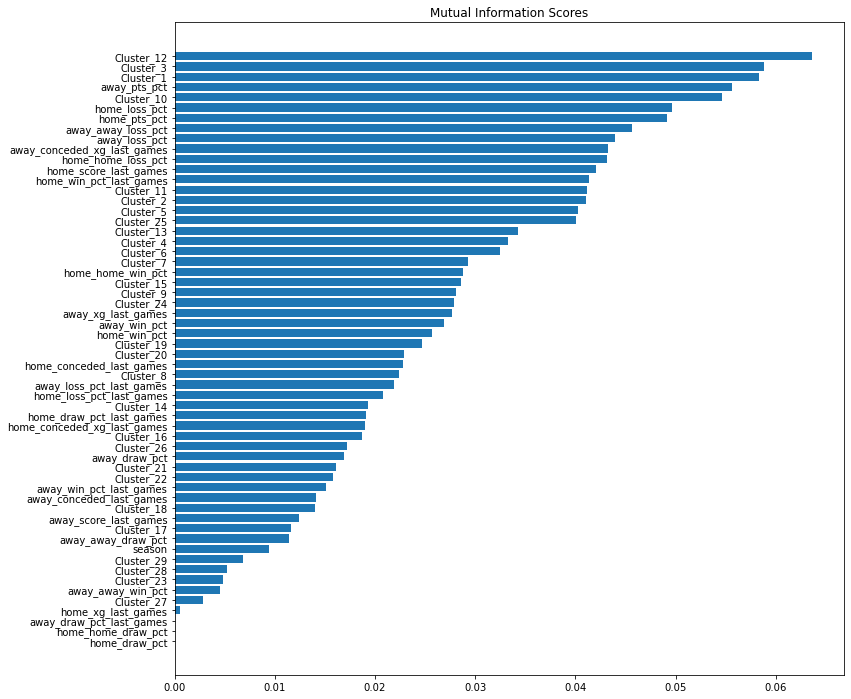

In [179]:
display(X_train)
second_mi_scores = hf.make_mi_scores(X_train, y_train)
hf.plot_mi_scores(second_mi_scores)

In [180]:
X_train, X_test = hf.apply_pca_datasets(X_train, X_test, second_mi_scores)

Total features to consider when doing the PCA: 54


In [181]:
if run_random_search: hf.run_random_forest_random_search(X_train, y_train)
    
# Best models found by the RandomSearch algorithm
# GradientBoostingClassifier(learning_rate=0.05, n_estimators=200, random_state=0)
# RandomForestClassifier(criterion='entropy', max_depth=50, max_features='log2',
#                        min_samples_leaf=2, min_samples_split=10,
#                        n_estimators=2000, random_state=0)

,season,home_pts_pct,home_win_pct,home_draw_pct,home_loss_pct,home_home_win_pct,home_home_draw_pct,home_home_loss_pct,home_win_pct_last_games,home_draw_pct_last_games,...,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54
0,2017.0,36.666667,30.000000,20.000000,50.000000,40.000000,20.000000,40.000000,40.0,0.0,...,0.041941,0.039997,0.033460,0.011445,-0.029195,4.288479e-15,2.820522e-16,2.153227e-16,6.426486e-16,-1.661024e-16
1,2017.0,43.333333,30.000000,40.000000,30.000000,33.333333,33.333333,33.333333,20.0,40.0,...,-0.096889,-0.119189,0.037254,0.011399,-0.071709,-8.428944e-16,1.035465e-15,1.064892e-15,-5.307218e-16,3.325709e-17
2,2017.0,26.666667,20.000000,20.000000,60.000000,20.000000,0.000000,80.000000,20.0,0.0,...,-0.068181,-0.126532,-0.050085,-0.036916,-0.068236,-9.584591e-16,3.827669e-17,7.382313e-17,-1.592548e-16,-1.138644e-16
3,2017.0,40.000000,30.000000,30.000000,40.000000,40.000000,40.000000,20.000000,20.0,20.0,...,-0.140823,0.004974,0.049454,0.008060,0.002684,-7.383953e-16,-2.486001e-16,-9.549913e-17,1.608694e-16,-1.689692e-16
4,2017.0,46.666667,40.000000,20.000000,40.000000,60.000000,20.000000,20.000000,20.0,40.0,...,0.067381,0.096181,0.043610,0.020720,0.014269,-1.527091e-16,-2.587596e-16,1.192612e-16,3.732925e-16,9.652959e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389,2021.0,19.819820,13.513514,18.918919,67.567568,16.666667,16.666667,66.666667,0.0,20.0,...,0.133847,0.089229,-0.089598,-0.040365,0.011710,-2.187623e-16,5.378841e-17,1.499376e-17,-3.802817e-17,1.545271e-17
1390,2021.0,81.081081,75.675676,16.216216,8.108108,77.777778,11.111111,11.111111,80.0,20.0,...,0.004352,-0.086464,-0.021714,0.008775,-0.017675,3.691081e-17,1.828445e-17,1.075465e-17,5.475688e-17,-1.287813e-17
1391,2021.0,80.180180,72.972973,21.621622,5.405405,77.777778,22.222222,0.000000,80.0,20.0,...,0.075077,0.171954,0.001389,0.031297,-0.011477,6.259379e-17,-2.363236e-17,-4.376465e-17,1.569613e-18,-1.047882e-17
1392,2021.0,31.531532,18.918919,37.837838,43.243243,27.777778,33.333333,38.888889,40.0,20.0,...,-0.096925,0.020244,-0.043974,0.049827,-0.062626,-6.930634e-17,-5.284843e-17,5.711199e-18,2.160378e-17,4.930959e-18


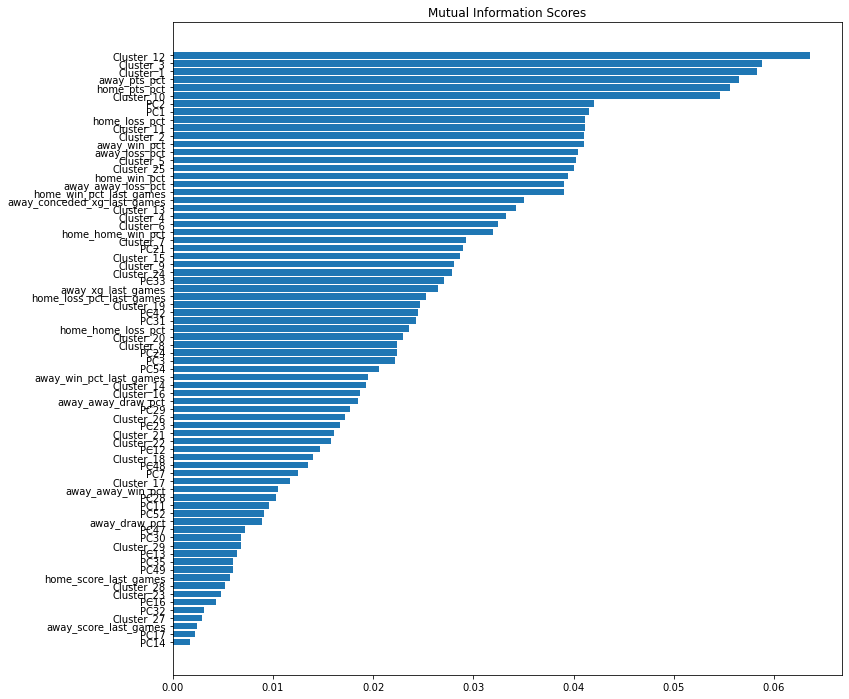

In [182]:
display(X_train)
min_mi_score=0.001
third_mi_scores = hf.make_mi_scores(X_train, y_train)
hf.plot_mi_scores(third_mi_scores[third_mi_scores > min_mi_score])

Results for model logistic_regression:
Training score: 0.5265593976431757
Classification Report:
              precision    recall  f1-score   support

           A       0.53      0.56      0.55        86
           D       0.00      0.00      0.00        52
           H       0.58      0.81      0.68       123

    accuracy                           0.57       261
   macro avg       0.37      0.46      0.41       261
weighted avg       0.45      0.57      0.50       261

Confusion Matrix:
[[100   0  23]
 [ 33   0  19]
 [ 38   0  48]]


Times when H was predicted: 171 (0.66)
Times when D was predicted: 0 (0.0)
Times when A was predicted: 90 (0.34)

Model profit: 2296.0
Maximum negative sequence:  8
Maximum positive sequence:  8


,outcome,pred,away_probs,draw_probs,home_probs,home_odds,away_odds,draw_odds,profit,progress
1394,A,H,0.131076,0.228947,0.639976,2.66,2.79,3.21,-100.0,2000.0
1395,H,H,0.146062,0.355998,0.497941,1.67,5.31,3.90,67.0,1967.0
1396,H,H,0.241951,0.288665,0.469383,2.95,2.43,3.39,195.0,2162.0
1397,H,H,0.135703,0.196476,0.667821,1.23,13.00,6.68,23.0,2185.0
1398,H,A,0.422840,0.271128,0.306033,2.06,3.65,3.49,-100.0,2085.0
...,...,...,...,...,...,...,...,...,...,...
1650,D,H,0.290327,0.316718,0.392956,3.14,2.31,3.44,-100.0,4156.0
1651,H,A,0.648180,0.181061,0.170759,5.18,1.64,4.16,-100.0,4056.0
1652,H,H,0.269375,0.251660,0.478965,2.61,2.68,3.46,161.0,4217.0
1653,H,H,0.125415,0.205918,0.668667,1.21,12.68,7.30,21.0,4238.0


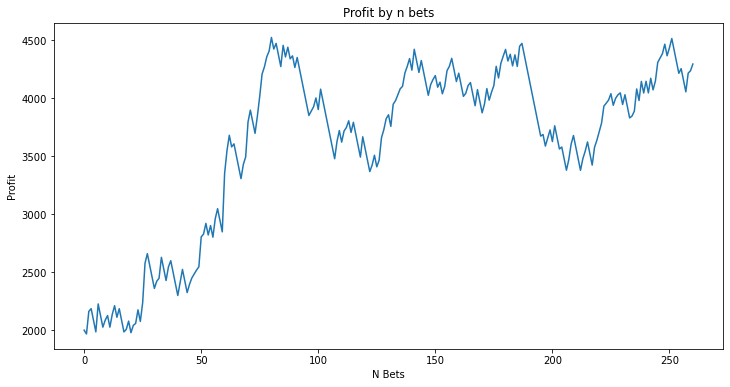

Results for model naive_bayes:
Training score: 0.47993862974136825
Classification Report:
              precision    recall  f1-score   support

           A       0.48      0.52      0.50        86
           D       0.17      0.15      0.16        52
           H       0.64      0.63      0.64       123

    accuracy                           0.50       261
   macro avg       0.43      0.44      0.43       261
weighted avg       0.50      0.50      0.50       261

Confusion Matrix:
[[78 19 26]
 [22  8 22]
 [21 20 45]]


Times when H was predicted: 121 (0.46)
Times when D was predicted: 47 (0.18)
Times when A was predicted: 93 (0.36)

Model profit: -1085.0
Maximum negative sequence:  7
Maximum positive sequence:  9


,outcome,pred,away_probs,draw_probs,home_probs,home_odds,away_odds,draw_odds,profit,progress
1394,A,H,1.885609e-03,1.520553e-01,0.846059,2.66,2.79,3.21,-100.0,2000.0
1395,H,H,6.698970e-05,7.301662e-02,0.926916,1.67,5.31,3.90,67.0,1967.0
1396,H,D,2.859838e-01,6.897252e-01,0.024291,2.95,2.43,3.39,-100.0,1867.0
1397,H,H,3.384771e-10,3.388224e-06,0.999997,1.23,13.00,6.68,23.0,1890.0
1398,H,D,9.794411e-02,8.524905e-01,0.049565,2.06,3.65,3.49,-100.0,1790.0
...,...,...,...,...,...,...,...,...,...,...
1650,D,D,1.328388e-02,7.359463e-01,0.250770,3.14,2.31,3.44,244.0,1036.0
1651,H,A,9.696031e-01,2.930976e-02,0.001087,5.18,1.64,4.16,-100.0,936.0
1652,H,D,1.008655e-01,5.331829e-01,0.365952,2.61,2.68,3.46,-100.0,836.0
1653,H,H,9.849319e-06,7.692569e-03,0.992298,1.21,12.68,7.30,21.0,857.0


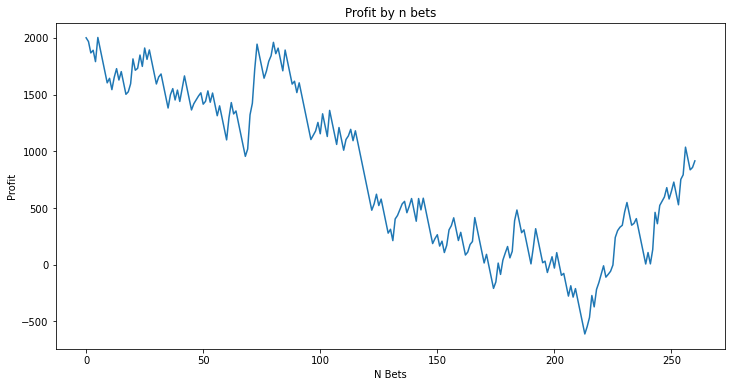

Results for model decision_tree:
Training score: 0.4505092700033522
Classification Report:
              precision    recall  f1-score   support

           A       0.41      0.48      0.44        86
           D       0.13      0.04      0.06        52
           H       0.53      0.63      0.58       123

    accuracy                           0.46       261
   macro avg       0.36      0.38      0.36       261
weighted avg       0.41      0.46      0.43       261

Confusion Matrix:
[[78  7 38]
 [29  2 21]
 [39  6 41]]


Times when H was predicted: 146 (0.56)
Times when D was predicted: 15 (0.06)
Times when A was predicted: 100 (0.38)

Model profit: 1243.0
Maximum negative sequence:  8
Maximum positive sequence:  6


,outcome,pred,away_probs,draw_probs,home_probs,home_odds,away_odds,draw_odds,profit,progress
1394,A,H,0.076923,0.025641,0.897436,2.66,2.79,3.21,-100.0,2000.0
1395,H,H,0.200000,0.200000,0.600000,1.67,5.31,3.90,67.0,1967.0
1396,H,A,0.615385,0.384615,0.000000,2.95,2.43,3.39,-100.0,1867.0
1397,H,H,0.266667,0.066667,0.666667,1.23,13.00,6.68,23.0,1890.0
1398,H,H,0.360000,0.160000,0.480000,2.06,3.65,3.49,106.0,1996.0
...,...,...,...,...,...,...,...,...,...,...
1650,D,H,0.291667,0.166667,0.541667,3.14,2.31,3.44,-100.0,2743.0
1651,H,H,0.150000,0.300000,0.550000,5.18,1.64,4.16,418.0,3161.0
1652,H,H,0.083333,0.416667,0.500000,2.61,2.68,3.46,161.0,3322.0
1653,H,H,0.076923,0.000000,0.923077,1.21,12.68,7.30,21.0,3343.0


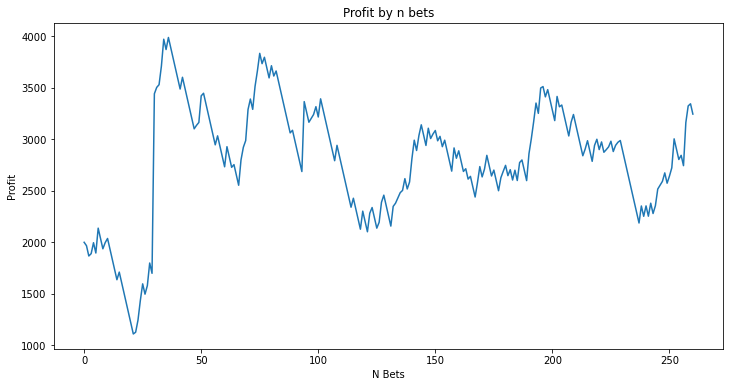

Results for model random_forest:
Training score: 0.5351795982568783
Classification Report:
              precision    recall  f1-score   support

           A       0.52      0.48      0.50        86
           D       0.00      0.00      0.00        52
           H       0.58      0.85      0.69       123

    accuracy                           0.56       261
   macro avg       0.37      0.44      0.40       261
weighted avg       0.44      0.56      0.49       261

Confusion Matrix:
[[105   0  18]
 [ 32   0  20]
 [ 45   0  41]]


Times when H was predicted: 182 (0.7)
Times when D was predicted: 0 (0.0)
Times when A was predicted: 79 (0.3)

Model profit: 1818.0
Maximum negative sequence:  7
Maximum positive sequence:  8


,outcome,pred,away_probs,draw_probs,home_probs,home_odds,away_odds,draw_odds,profit,progress
1394,A,H,0.195037,0.246706,0.558258,2.66,2.79,3.21,-100.0,2000.0
1395,H,H,0.256310,0.284356,0.459334,1.67,5.31,3.90,67.0,1967.0
1396,H,A,0.369569,0.299161,0.331270,2.95,2.43,3.39,-100.0,1867.0
1397,H,H,0.142027,0.180706,0.677268,1.23,13.00,6.68,23.0,1890.0
1398,H,H,0.313465,0.274463,0.412072,2.06,3.65,3.49,106.0,1996.0
...,...,...,...,...,...,...,...,...,...,...
1650,D,H,0.327926,0.324904,0.347170,3.14,2.31,3.44,-100.0,3678.0
1651,H,A,0.520228,0.229398,0.250374,5.18,1.64,4.16,-100.0,3578.0
1652,H,H,0.332838,0.247170,0.419991,2.61,2.68,3.46,161.0,3739.0
1653,H,H,0.179705,0.190429,0.629866,1.21,12.68,7.30,21.0,3760.0


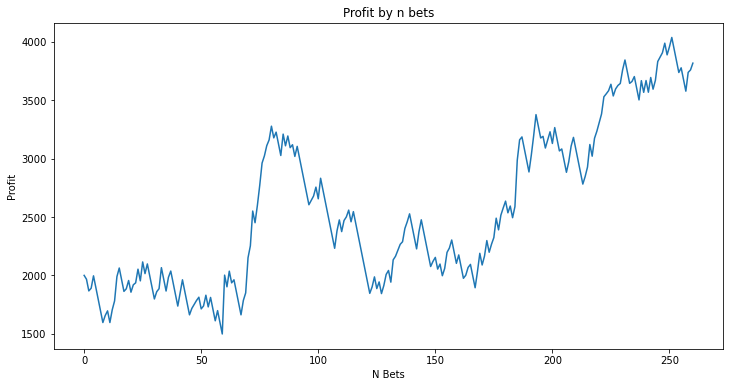

Results for model svm:
Training score: 0.5287176710244708
Classification Report:
              precision    recall  f1-score   support

           A       0.52      0.41      0.46        86
           D       0.00      0.00      0.00        52
           H       0.55      0.86      0.67       123

    accuracy                           0.54       261
   macro avg       0.36      0.42      0.38       261
weighted avg       0.43      0.54      0.47       261

Confusion Matrix:
[[106   0  17]
 [ 37   0  15]
 [ 51   0  35]]


Times when H was predicted: 194 (0.74)
Times when D was predicted: 0 (0.0)
Times when A was predicted: 67 (0.26)

Model profit: 877.0
Maximum negative sequence:  7
Maximum positive sequence:  8


,outcome,pred,away_probs,draw_probs,home_probs,home_odds,away_odds,draw_odds,profit,progress
1394,A,H,0.167303,0.260753,0.571944,2.66,2.79,3.21,-100.0,2000.0
1395,H,H,0.204738,0.239204,0.556058,1.67,5.31,3.90,67.0,1967.0
1396,H,H,0.255314,0.260832,0.483854,2.95,2.43,3.39,195.0,2162.0
1397,H,H,0.182583,0.223804,0.593613,1.23,13.00,6.68,23.0,2185.0
1398,H,H,0.325614,0.235244,0.439142,2.06,3.65,3.49,106.0,2291.0
...,...,...,...,...,...,...,...,...,...,...
1650,D,H,0.283566,0.247309,0.469125,3.14,2.31,3.44,-100.0,2737.0
1651,H,A,0.503890,0.248384,0.247726,5.18,1.64,4.16,-100.0,2637.0
1652,H,H,0.269246,0.246745,0.484009,2.61,2.68,3.46,161.0,2798.0
1653,H,H,0.171017,0.230303,0.598679,1.21,12.68,7.30,21.0,2819.0


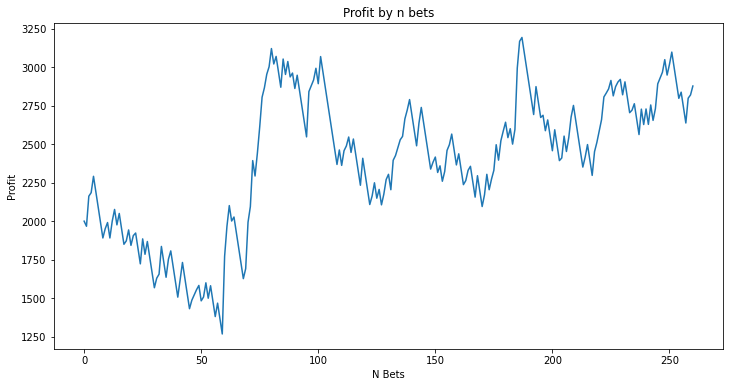

Results for model voting_classifier:


In [ ]:
import json
from joblib import load
from sklearn.ensemble import VotingClassifier
import pickle

dir_path = f"leagues_v2/{league}/best_models/{season_test}"
models_path = f"{dir_path}/best_models.json"
with open(models_path, 'rb') as file:
    models_dict = json.load(file)
    
models = models_dict.keys()
voting_classifier_estimators = []
for model in models:
    model_path = f"{dir_path}/{model}.joblib"
    try:
        loaded_model = load(model_path)
    except:
        with open(model_path, 'rb') as file:
            loaded_model = pickle.load(file)
    models_dict[model]['estimator'] = loaded_model
    voting_classifier_estimators.append((model, models_dict[model]['estimator']))
    
models_dict['voting_classifier'] = {'estimator': VotingClassifier(estimators=voting_classifier_estimators, voting='soft')}

progress_data = []
for model in models_dict.keys():
    print(f"Results for model {model}:")
    score = models_dict[model].get('score')
    if score:
        print('Training score:', score)
    my_pipeline = hf.build_pipeline(X_train, y_train, models_dict[model]['estimator'])
    test_results_df = hf.build_pred_df(my_pipeline, X_test, y_test, odds_test)
    display(test_results_df)
    hf.plot_betting_progress(test_results_df)
    progress_data.append([test_results_df['profit'].sum(), score])
    
cols = ['profit', 'training_score']
profit_df = pd.DataFrame(progress_data, columns=cols, index=models_dict.keys())

In [ ]:
display(profit_df)